### Import Libraries
 numpy: For numerical operations on arrays.<br>
 rasterio: For reading and manipulating raster files (e.g., .tif files).<br>
 scikit-learn: To calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).<br>
 scipy: For calculating the Pearson correlation coefficient.<br>
 pandas: To save the calculated metrics in an Excel file.




In [49]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Define a Function to Load Raster Data

In [35]:
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first band
        transform = src.transform  # Geotransform information
        crs = src.crs  # Coordinate reference system
        nodata = src.nodata  # NoData value
        return data, transform, crs, nodata


### Resample Raster Data to Match Another Raster

In [37]:
def resample_raster(src_data, src_transform, src_crs, target_transform, target_shape, target_crs):
    resampled_data = np.empty(target_shape, dtype=src_data.dtype)
    reproject(
        source=src_data,
        destination=resampled_data,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=target_transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest
    )
    return resampled_data


### Load and Align Reference and Predicted Data

In [38]:
reference_path =r"D:\canopyHeight_FCH.tif"
predicted_path =r"D:\BGL_CanopyHeight_ETH.tif"

reference_data, reference_transform, reference_crs, _ = load_raster(reference_path)
predicted_data, predicted_transform, predicted_crs, predicted_nodata = load_raster(predicted_path)

# Check if shapes match, if not, resample the predicted data
if reference_data.shape != predicted_data.shape:
    predicted_data = resample_raster(
        predicted_data,
        predicted_transform,
        predicted_crs,
        reference_transform,
        reference_data.shape,
        reference_crs
    )


### Mask Reference Data Using Predicted Data

In [39]:
def mask_reference_using_predicted(reference_data, predicted_data, predicted_nodata):
    # Create a mask where the predicted data is not equal to the NoData value
    mask = predicted_data != predicted_nodata
    # Apply the mask to the reference data
    masked_reference = np.where(mask, reference_data, np.nan)
    return masked_reference

masked_reference_data = mask_reference_using_predicted(reference_data, predicted_data, predicted_nodata)

### Flatten Data and Remove Invalid Values

In [42]:
mask = ~np.isnan(masked_reference_data) & ~np.isinf(masked_reference_data) & ~np.isinf(predicted_data)
masked_ref_flat = masked_reference_data[mask]
predicted_flat = predicted_data[mask]
masked_ref_flat = masked_ref_flat.astype(np.float64)
predicted_flat = predicted_flat.astype(np.float64)

### Visualization

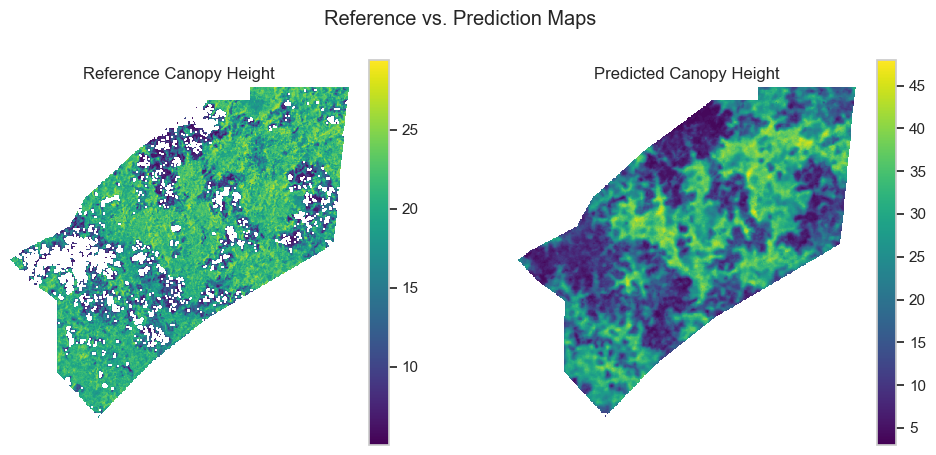

In [69]:

# 1. Reference vs. Prediction Maps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(reference_data, cmap='viridis')
plt.colorbar()
plt.title("Reference Canopy Height")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_data, cmap='viridis')
plt.colorbar()
plt.title("Predicted Canopy Height")
plt.axis('off')

plt.suptitle("Reference vs. Prediction Maps")
plt.show()


### Calculate metrics
Mean Absolute Error (MAE): Average magnitude of errors.<br>
Root Mean Squared Error (RMSE): Measures the error magnitude.<br>
Pearson Correlation: Indicates correlation between reference and predicted data.<br>
Accuracy Percentage: Custom metric showing how close the predictions are to reference data<br>.

In [51]:
mae = mean_absolute_error(masked_ref_flat, predicted_flat)
rmse = np.sqrt(mean_squared_error(masked_ref_flat, predicted_flat))
correlation, _ = pearsonr(masked_ref_flat, predicted_flat)
accuracy = 100 - (mae / np.nanmean(masked_ref_flat) * 100)

### Save Results to an Excel File

In [79]:
results = {
    "Metric": ["Mean Absolute Error (MAE)", "Root Mean Square Error (RMSE)", "Pearson Correlation Coefficient", "Accuracy Percentage"],
    "Value": [mae, rmse, correlation, accuracy]
}
# Save the results to an Excel file
output_path = r"D:\canopy_height21.xlsx"

results_df.to_excel(output_path, index=False)

print(f"Results saved to {output_path}")

Results saved to D:\canopy_height21.xlsx


### Create a DataFrame for metrics

In [77]:

metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'Correlation'],
    'Value': [mae, rmse, correlation]
})

# Display in a formatted table
styled_df = metrics_df.style.set_table_attributes('style="width: 50%; margin: auto;"')\
                            .set_caption('Model Performance Metrics')\
                            .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
display(styled_df)

,Metric,Value
0,MAE,6.874516
1,RMSE,8.688360
2,Correlation,0.703318
